# Visualization and processing of tractography data

Tractography data are composed of estimated trajectories called tracks, which themselves contain a set of points. They can be stored inside 4 different file formats: TRK, TCK, VTK and VTP, the latter being rarely used outside Anima. In TRK, tracks' points are stored in voxel coordinates. In the three other file formats, they are stored in real coordinates.

Processing and visualizing tractography data requires to know about differences of orientation conventions between softwares. We will present this in first part, before showing how to switch between distinct track formats and visualize the data without orientation errors.

## Orientation convention between softwares

Most softwares (nibabel, FSL... and the ones using it) use RAS convention to express tracks' point coordinates (x-axis from left to right, y-axis from posterior to anterior, z-axis from inferior to superior). 
But ITK-based softwares like MI-Brain (a track visualisation tool) or Anima use LPS convention (x-axis from right to left, y-axis from anterior to posterior, z-axis from inferior to superior).

Consequently, given a track file in RAS convention, if one wants to process it with Anima, visualize it with MI-Brain, or do anything else with a LPS software, one must first rotate it by 180° around z-axis. This replaces x and y positions by their opposite, and hence enables to move from RAS convention to LPS or from LPS to RAS. The same rotation must thus also be used when moving from a LPS software to a RAS one.

The script rotation.py of Anima-Tools enables to do this rotation. It works with vtp and vtk files. See an example below with a track file inside Anima-Tools.

In [24]:
animaToolsPath = "" #Write the path of your Anima-Tools folder here.
#This notebook requires Dipy, MRtrix3 and Anima, and assumes that their commands are in your path.

In [2]:
from subprocess import call

call(["python3", animaToolsPath+"/scripts/rotation.py", 
      "-i", animaToolsPath+"/examples/data_changing-tracks-format/data/tracks_file_RAS.vtk", 
      "-o", animaToolsPath+"/examples/data_changing-tracks-format/data/tracks_file_LPS.vtk", "-a", "180", "-z"])
#Performs a rotation by 180° around z axis. Note that "-a 180" could be omitted since the angle has a default value which is 180°.

0

As most track files, tracks generated by Trekker PTT or MRtrix3 iFod2 algorithms and pre-segmented bundles from HCP105 use RAS convention.

Trackvis, MRview, and Nibabel-based visualisation tools use RAS convention. Mi-Brain and MedInria use LPS convention. We will use these visualization tools in next part.

## Track formats conversion
We will see in this part how to move between different track files formats without orientation error.

### TRK to TCK conversion
Let's start with a trk file inside Anima-Tools (examples/data_changing-tracks-format/data folder) : tracks.trk. It contains tracks coming from the left part of the Arcuate Fascicle (AF).

To convert it to TCK, one needs first to know its voxel to rasmm 4x4 matrix. The following Python code enables to do this.

In [3]:
from nibabel.streamlines import trk

trkObject = trk.TrkFile("trk_reader")
trackImg = trkObject.load(animaToolsPath+"/examples/data_changing-tracks-format/data/tracks.trk")
print(trackImg.header['voxel_to_rasmm'])

[[  -1.25    0.      0.     90.  ]
 [   0.      1.25    0.   -126.  ]
 [   0.      0.      1.25  -72.  ]
 [   0.      0.      0.      1.  ]]


We then need to provide a reference image (typically a .nii.gz file) with a qform/sform matrix similar to the voxel to rasmm matrix of the TRK file. `fslhd` can enable to get the qform/sform matrix:

In [4]:
from subprocess import call #Only if it has not already been done in the first part

call(["fslhd", animaToolsPath+"/examples/data_changing-tracks-format/data/FA.nii.gz"])

filename	/home/gville/Documents/Anima-Tools/src/examples/data_changing-tracks-format/data/FA.nii.gz

sizeof_hdr	348
data_type	FLOAT64
dim0		3
dim1		145
dim2		174
dim3		145
dim4		1
dim5		1
dim6		1
dim7		1
vox_units	mm
time_units	Unknown
datatype	64
nbyper		8
bitpix		64
pixdim0		-1.000000
pixdim1		1.250000
pixdim2		1.250000
pixdim3		1.250000
pixdim4		1.000000
pixdim5		1.000000
pixdim6		1.000000
pixdim7		1.000000
vox_offset	352
cal_max		0.000000
cal_min		0.000000
scl_slope	1.000000
scl_inter	0.000000
phase_dim	0
freq_dim	0
slice_dim	0
slice_name	Unknown
slice_code	0
slice_start	0
slice_end	0
slice_duration	0.000000
toffset		0.000000
intent		Unknown
intent_code	0
intent_name	
intent_p1	0.000000
intent_p2	0.000000
intent_p3	0.000000
qform_name	Unknown
qform_code	0
qto_xyz:1	-1.250000 0.000000 -0.000000 90.000000 
qto_xyz:2	0.000000 1.250000 -0.000000 -126.000000 
qto_xyz:3	0.000000 0.000000 1.250000 -72.000000 
qto_xyz:4	0.000000 0.000000 0.000000 1.000000 
qform_xorient	Right-to-Left
qform

0

Here we see that the qform and sform matrixes of this FA image are similar to the previous voxel to rasmm matrix. So this image can be used as a reference for tracks.trk. 

Then we can convert from our tracks.trk file to a tck one (let's call it tracks.tck) using dipy, with the following command:

In [18]:
call(["dipy_convert_tractogram", "--reference", animaToolsPath+"/examples/data_changing-tracks-format/data/FA.nii.gz", 
      "--out_tractogram", animaToolsPath+"/examples/data_changing-tracks-format/data/tracks_RAS.tck", 
      animaToolsPath+"/examples/data_changing-tracks-format/data/tracks.trk"])

0

The reverse conversion is also doable with:

In [6]:
call(["dipy_convert_tractogram", "--reference", animaToolsPath+"/examples/data_changing-tracks-format/data/FA.nii.gz", 
      "--out_tractogram", animaToolsPath+"/examples/data_changing-tracks-format/data/new_tracks_file.trk", 
      animaToolsPath+"/examples/data_changing-tracks-format/data/tracks_RAS.tck"])

0

TRK files can be visualized with Trackvis. They can be put on top of a reference image, whose qform/sform matrix is similar to the TRK file's voxel to rasmm matrix.

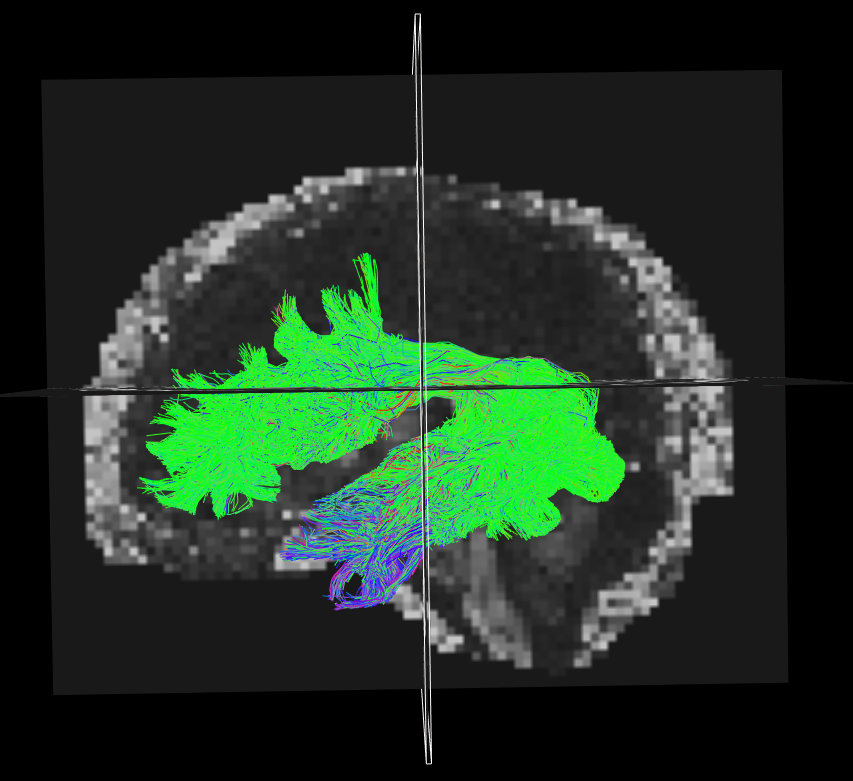

In [7]:
from IPython.display import Image, display

im = Image(filename=animaToolsPath+"/examples/data_changing-tracks-format/images/tracks_trk_trackvis.png", width=300)
display(im)

TCK files can be visualized with mrview, on top of a reference image as well.

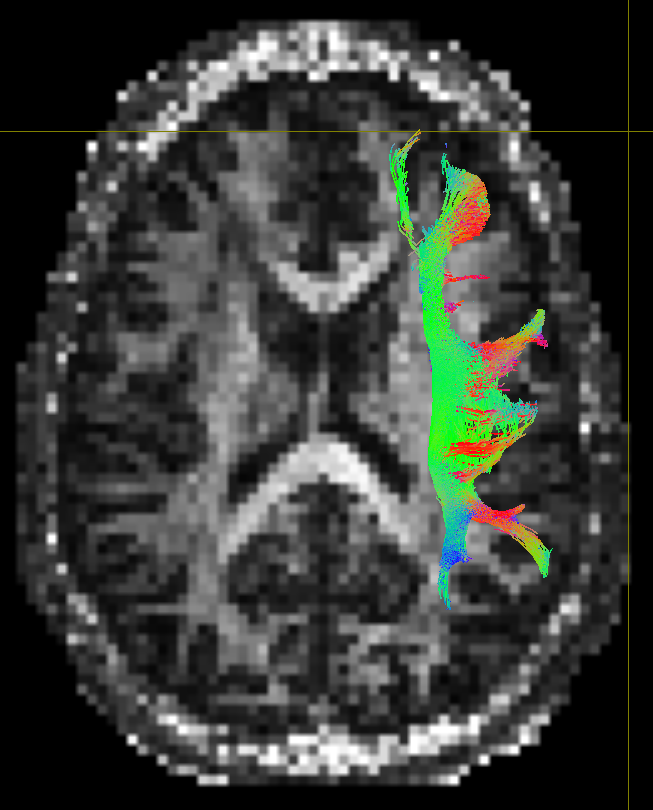

In [8]:
call(["mrview", "-load", animaToolsPath+"/examples/data_changing-tracks-format/data/FA.nii.gz", 
      "-tractography.load", animaToolsPath+"/examples/data_changing-tracks-format/data/tracks_RAS.tck"])

im = Image(filename=animaToolsPath+"/examples/data_changing-tracks-format/images/tracks_tck_mrview.png", width=300)
display(im)

### TCK to VTK conversion
This is simply doable with the MRtrix3 command `tckconvert`:

In [19]:
call(["tckconvert", animaToolsPath+"/examples/data_changing-tracks-format/data/tracks_RAS.tck", 
      animaToolsPath+"/examples/data_changing-tracks-format/data/tracks_RAS.vtk"])

0

Or for reverse conversion :

In [10]:
call(["tckconvert", animaToolsPath+"/examples/data_changing-tracks-format/data/tracks_RAS.vtk", 
      animaToolsPath+"/examples/data_changing-tracks-format/data/new_tracks_file.tck"])

tckconvert: [ERROR] VTK Reader only supports BINARY input


1

Note that the above command will output an error if the input track file uses ASCII format, since MRtrix3 only supports binary storage format for reading streamlines from a VTK file (https://community.mrtrix.org/t/tckconvert-error/5323/2).

VTK files can be visualized with MI-Brain, a VTK-based visualization software which also supports TRK, TCK and VTP. But MI-Brain uses LPS convention. So if the input track file uses RAS convention, we must first put it in LPS convention by rotating the points by 180° around z-axis (see previous part). We can use Anima-Tools's rotation script to do that:

In [21]:
call(["python3", animaToolsPath+"/scripts/rotation.py", "-i", animaToolsPath+"/examples/data_changing-tracks-format/data/tracks_RAS.vtk", 
      "-o", animaToolsPath+"/examples/data_changing-tracks-format/data/tracks_LPS.vtk", "-a", "180", "-z"])

0

Then, the output can be visualized correctly with MI-Brain:

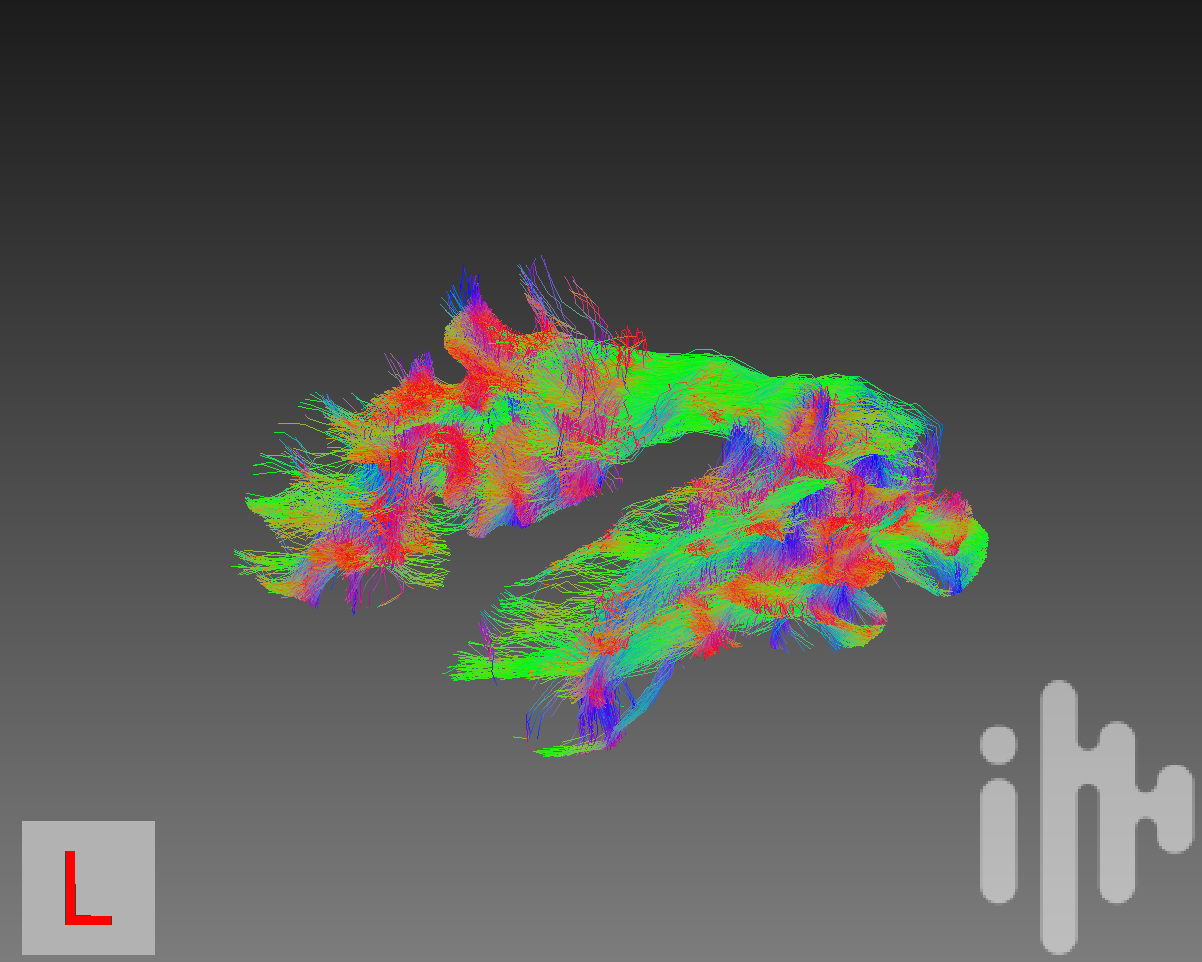

In [12]:
im = Image(filename=animaToolsPath+"/examples/data_changing-tracks-format/images/tracks_vtk_mibrain.png", width=300)
display(im)

### VTK to VTP conversion
This is simply doable with the anima command animaConvertShapes :

In [22]:
call(["animaConvertShapes", "-i", animaToolsPath+"/examples/data_changing-tracks-format/data/tracks_LPS.vtk", 
      "-o", animaToolsPath+"/examples/data_changing-tracks-format/data/tracks_LPS.vtp"])

0

Or for reverse conversion : 

In [23]:
call(["animaConvertShapes", "-i", animaToolsPath+"/examples/data_changing-tracks-format/data/tracks_LPS.vtp", 
      "-o", animaToolsPath+"/examples/data_changing-tracks-format/data/new_tracks_file.vtk"])

0

VTP files can be visualized with MedInria or MI-Brain. As MI-Brain, MedInria uses LPS convention, so one should check that the tracks file is in LPS convention as well.

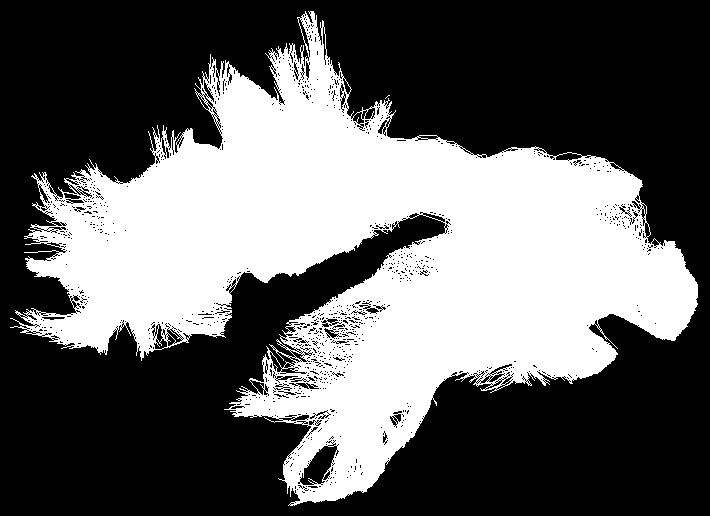

In [15]:
im = Image(filename=animaToolsPath+"/examples/data_changing-tracks-format/images/tracks_vtp_medinria.png", width=300)
display(im)